# Giving tokens a label - How to categorize tokens


The first part of this Notebook contains elements that explain how to label tokens and how the functions work.

The second part shows how all tokens are labelled that are used for our delphi language models.3


In [23]:
# autoreload
%load_ext autoreload
%autoreload 2

from pprint import pprint 

import spacy
from tqdm.auto import tqdm

import delphi

from delphi.eval import token_labelling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# 1) How to use the token labelling functions

We analyze a simple sentence and receive the respective tokens with their analyzed attributes.  
The grammatical/linguistic analysis is done by a model provided by spaCy for the English language.

In [15]:
# Load the english model
nlp = spacy.load("en_core_web_sm")

# Create a Doc object from a given text
doc = nlp("Peter is a person")

token = doc[0]
for tok in doc:
    print(tok,"\t", tok.pos_, "\t", tok.dep_, "\t", tok.ent_type_)

Peter 	 PROPN 	 nsubj 	 PERSON
is 	 AUX 	 ROOT 	 
a 	 DET 	 det 	 
person 	 NOUN 	 attr 	 


Let's get the label for our custom token that we just printed.

In [5]:
from delphi.eval import token_labelling

label = token_labelling.label_single_token(token)
pprint(label)

{'Capitalized': True,
 'Is Adjective': False,
 'Is Adposition': False,
 'Is Adverb': False,
 'Is Auxiliary': False,
 'Is Coordinating conjuction': False,
 'Is Determiner': False,
 'Is Interjunction': False,
 'Is Named Entity': True,
 'Is Noun': False,
 'Is Numeral': False,
 'Is Other': False,
 'Is Particle': False,
 'Is Pronoun': False,
 'Is Proper Noun': True,
 'Is Punctuation': False,
 'Is Subordinating conjuction': False,
 'Is Symbol': False,
 'Is Verb': False,
 'Starts with space': False}


Let's get an understanding of what the labels acutally mean.
Use this function to receive an explanation for a single token.

In [6]:
token_labelling.explain_token_labels(token)

-------- Explanation of token labels --------
Token text:          Peter
Token dependency:    nominal subject
Token POS:           proper noun
---------------- Token labels ---------------
  0   Starts with space    False
  1   Capitalized          True
  2   Is Adjective         False
  3   Is Adposition        False
  4   Is Adverb            False
  5   Is Auxiliary         False
  6   Is Coordinating conjuction False
  7   Is Determiner        False
  8   Is Interjunction     False
  9   Is Noun              False
 10   Is Numeral           False
 11   Is Particle          False
 12   Is Pronoun           False
 13   Is Proper Noun       True
 14   Is Punctuation       False
 15   Is Subordinating conjuction False
 16   Is Symbol            False
 17   Is Verb              False
 18   Is Other             False
 19   Is Named Entity      True


If you are interested in all the possible labels a token can have, that spaCy is capable of assigning, then call the same function but without any argument:
```Python
>>> token_labelling.explain_token_labels()
```

### Batched token labelling
Next, let us analyze a batch of sentences and have them labelled.
> In the example below the input sentences are not yet tokenized, so spaCy uses its internal tokenizer.

In [9]:
sentences = [
    "Peter is a person."
]
labels = token_labelling.label_batch_sentences(sentences, tokenized=False, verbose=True)

print(len(labels[0]))
print(labels[0])

Token: Peter
Starts with space | Capitalized | Is Adjective | Is Adposition | Is Adverb | Is Auxiliary | Is Coordinating conjuction | Is Determiner | Is Interjunction | Is Noun | Is Numeral | Is Particle | Is Pronoun | Is Proper Noun | Is Punctuation | Is Subordinating conjuction | Is Symbol | Is Verb | Is Other | Is Named Entity
False             | True        | False        | False         | False     | False        | False                      | False         | False            | False   | False      | False       | False      | True           | False          | False                       | False     | False   | False    | True           
---
Token: is
Starts with space | Capitalized | Is Adjective | Is Adposition | Is Adverb | Is Auxiliary | Is Coordinating conjuction | Is Determiner | Is Interjunction | Is Noun | Is Numeral | Is Particle | Is Pronoun | Is Proper Noun | Is Punctuation | Is Subordinating conjuction | Is Symbol | Is Verb | Is Other | Is Named Entity
False           

Now with our own tokenization. E.g. the one from our TinyStories models.

In [19]:
sentences = [
    ["This ", "is ", "a ", "sentence", "."]
]
labelled_sentences = token_labelling.label_batch_sentences(sentences, tokenized=True, verbose=False)

print(len(labelled_sentences[0]))
print(labelled_sentences[0])

5
[{'Starts with space': False, 'Capitalized': True, 'Is Noun': True, 'Is Pronoun': False, 'Is Adjective': False, 'Is Verb': False, 'Is Adverb': False, 'Is Preposition': False, 'Is Conjunction': False, 'Is Interjunction': False, 'Is Named Entity': False}, {'Starts with space': False, 'Capitalized': False, 'Is Noun': False, 'Is Pronoun': False, 'Is Adjective': False, 'Is Verb': False, 'Is Adverb': True, 'Is Preposition': False, 'Is Conjunction': False, 'Is Interjunction': False, 'Is Named Entity': False}, {'Starts with space': False, 'Capitalized': False, 'Is Noun': False, 'Is Pronoun': False, 'Is Adjective': True, 'Is Verb': False, 'Is Adverb': False, 'Is Preposition': False, 'Is Conjunction': False, 'Is Interjunction': False, 'Is Named Entity': False}, {'Starts with space': False, 'Capitalized': False, 'Is Noun': True, 'Is Pronoun': False, 'Is Adjective': False, 'Is Verb': False, 'Is Adverb': False, 'Is Preposition': False, 'Is Conjunction': False, 'Is Interjunction': False, 'Is Named

# 2) Labelling all tokens in the dataset

Now we want to label all the tokens that our tokenizer knows - its entire vocabulary.

Using thy script in `scripts/label_all_tokens.py` we get the files:
- `src\delphi\eval\all_tokens_list.txt`
- `src\delphi\eval\labelled_token_ids_dict.pkl`

Let's load the tokenizer so that we can look at the labelled tokens.


In [4]:
# Get all the tokens of the tokenizer
from transformers import AutoTokenizer, PreTrainedTokenizer


# Decode a sentence
def decode(tokenizer: PreTrainedTokenizer, token_ids: list[int]) -> str:
    return tokenizer.decode(token_ids, skip_special_tokens=True)

model = "delphi-suite/delphi-llama2-100k"
tokenizer = AutoTokenizer.from_pretrained(model)
vocab_size = tokenizer.vocab_size
print("The vocab size is:", vocab_size)

c:\Users\joshu\anaconda3\envs\delphi2\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


The vocab size is: 4096


Load the pickle.

In [2]:
import pickle
path = "../src/delphi/eval/labelled_token_ids_dict.pkl"
# load 
with open(path, "rb") as f:
    labelled_token_ids_dict = pickle.load(f)

Look at some random tokens and their labels

In [5]:
import random
from pprint import pprint
# Get a random token id between 0 and 4000
token_id = random.randint(0, 4000)
# decode the token id
decoded_token = decode(tokenizer, [token_id])
# get the corresponding label
label = labelled_token_ids_dict[token_id]
# print the results
print("The token id is:", token_id)
print("The decoded token is:", decoded_token)
print("The label is:")
pprint(label)


The token id is: 2980
The decoded token is: four
The label is:
{'Capitalized': False,
 'Is Adjective': False,
 'Is Adposition': False,
 'Is Adverb': False,
 'Is Auxiliary': False,
 'Is Coordinating conjuction': False,
 'Is Determiner': False,
 'Is Interjunction': False,
 'Is Named Entity': False,
 'Is Noun': True,
 'Is Numeral': False,
 'Is Other': False,
 'Is Particle': False,
 'Is Pronoun': False,
 'Is Proper Noun': False,
 'Is Punctuation': False,
 'Is Subordinating conjuction': False,
 'Is Symbol': False,
 'Is Verb': False,
 'Starts with space': False}


# 3) Visualize the token label stats

Let's have a look at the statistics.

In [1]:
import pandas
import matplotlib.pyplot as plt  # install matplotlib, if necessary

In [6]:
"""
    Create a pandas dataframe from the labelled token ids dictionary
"""
# each item in the dictionary is a tuple (token_id, label), where label: dict[str, float]
# the dataframe should have the columns: token_id, label1, label2 ... labelN
# label1, label2 ... labelN are the keys of the label dictionary
# the values of the label dictionary are the probabilities of the label
# here we go:
df = pandas.DataFrame(labelled_token_ids_dict.items(), columns=["token_id", "label"])
# split the label column into multiple columns
df = df.join(pandas.DataFrame(df.pop('label').tolist()))
# Change datatype of columns to float
df = df.astype(int)

df.head()

,token_id,Starts with space,Capitalized,Is Adjective,Is Adposition,Is Adverb,Is Auxiliary,Is Coordinating conjuction,Is Determiner,Is Interjunction,...,Is Numeral,Is Particle,Is Pronoun,Is Proper Noun,Is Punctuation,Is Subordinating conjuction,Is Symbol,Is Verb,Is Other,Is Named Entity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


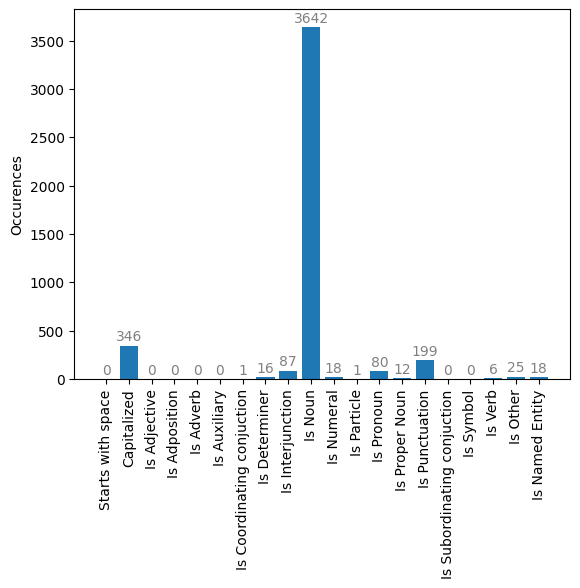

In [7]:
# visualize the occurences of TRUE per column
count = df[df==1].count()
index, values = count.index[1:], count.values[1:]

plt.figure()
#_ = plt.pie(values, autopct='%1.1f%%')
plt.bar(index, values)
# the values are plotted above the bars
for i, value in enumerate(values):
    plt.text(i, value+50, str(value), ha="center", color="grey")
plt.ylabel("Occurences")
# rotate x labels
_ = plt.xticks(rotation=90)


In [48]:
pprint(labelled_token_ids_dict[1000])

{'Capitalized': False,
 'Is Adjective': False,
 'Is Adposition': False,
 'Is Adverb': False,
 'Is Auxiliary': False,
 'Is Coordinating conjuction': False,
 'Is Determiner': False,
 'Is Interjunction': False,
 'Is Named Entity': False,
 'Is Noun': True,
 'Is Numeral': False,
 'Is Other': False,
 'Is Particle': False,
 'Is Pronoun': False,
 'Is Proper Noun': False,
 'Is Punctuation': False,
 'Is Subordinating conjuction': False,
 'Is Symbol': False,
 'Is Verb': False,
 'Starts with space': False}
